<a href="https://colab.research.google.com/github/peeyushgs/Data-Science-Projects/blob/main/Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>  Loan Default Prediction : Predicting whether a customer will default on a loan. </b>



In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score,recall_score,accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix,auc,r2_score,f1_score,plot_confusion_matrix,plot_roc_curve,plot_precision_recall_curve

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
Working_dir="/content/drive/MyDrive/Colab Notebooks/dat/"
loan_df=pd.read_csv(Working_dir+'lending_club_loans.csv',skiprows=1,low_memory=False)
descr_df=pd.read_csv(Working_dir+'LCDataDictionary.csv')

In [6]:
descr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   LoanStatNew  115 non-null    object
 1   Description  116 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [7]:
loan_df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [8]:
loan_df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,4.253500e+04,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,42535.000000,42506.000000,42535.000000,42535.000000,42506.000000,15609.000000,3651.000000,42506.000000,42506.000000,4.253500e+04,42506.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42390.0,0.0,42535.0,0.0,0.0,0.0,42506.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42390.0,42506.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41170.000000,42430.000000,0.0,0.0,0.0,0.0
mean,8.257026e+05,11089.722581,10821.585753,10139.830603,322.623063,6.913656e+04,13.373043,0.152449,713.052545,717.052545,1.081424,35.017618,59.175568,9.343951,0.058156,1.429786e+04,22.124406,11.849562,11.815891,12005.641023,11298.592611,9664.271346,2239.547094,1.515321,100.307353,13.956737,2612.720097,689.305302,676.382744,0.0,NaN,1.0,NaN,NaN,NaN,0.000094,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.143039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045227,0.000024,NaN,NaN,NaN,NaN
std,2.795409e+05,7410.938391,7146.914675,7131.686447,208.927216,6.409635e+04,6.726315,0.512406,36.188439,36.188439,1.527455,22.418427,47.145396,4.496274,0.245713,2.201844e+04,11.592811,125.376563,125.061859,9067.243728,9010.323570,7087.469380,2583.722104,7.827800,718.078716,159.621861,4385.198940,80.202882,119.011555,0.0,NaN,0.0,NaN,NaN,NaN,0.009700,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,29.359579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.208737,0.004855,NaN,NaN,NaN,NaN
min,7.047300e+04,500.000000,500.000000,0.000000,15.670000,1.896000e+03,0.000000,0.000000,610.000000,614.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,6.384795e+05,5200.000000,5000.000000,4950.000000,165.520000,4.000000e+04,8.200000,0.000000,685.000000,689.000000,0.000000,17.000000,0.000000,6.000000,0.000000,3.635000e+03,13.000000,0.000000,0.000000,5462.787435,4791.415000,4400.000000,657.100000,0.000000,0.000000,0.000000,211.370000,644.000000,640.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [9]:
loan_df["loan_status"].value_counts()

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                  513
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
Default                                                    1
Name: loan_status, dtype: int64

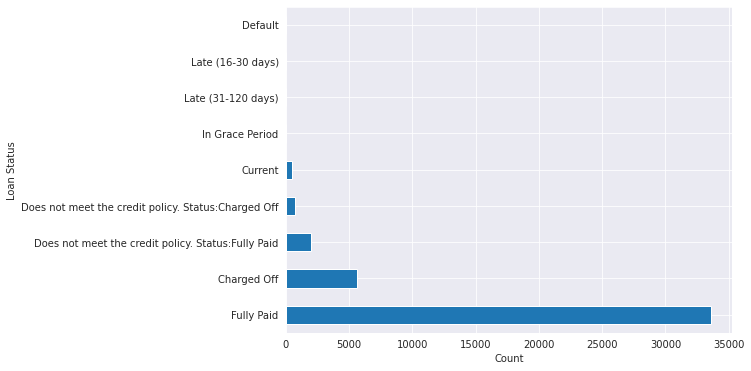

In [10]:
plt.figure(figsize= (8,6))
plt.ylabel('Loan Status')
plt.xlabel('Count')
loan_df['loan_status'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

In [11]:
loan_df=loan_df[loan_df["loan_status"]!='Current']
loan_df.dropna(subset=['loan_status'],inplace=True)
loan_df=loan_df.reset_index()
del loan_df['index']

In [12]:
# Encoding the loan status variable
dct = {"loan_status":{ "Fully Paid": 0, "Charged Off": 1,'Does not meet the credit policy. Status:Fully Paid':1,
'Does not meet the credit policy. Status:Charged Off':1,'In Grace Period':1,'Late (31-120 days)':1 ,'Late (16-30 days)':1,'Default':1}}
loan_df = loan_df.replace(dct)

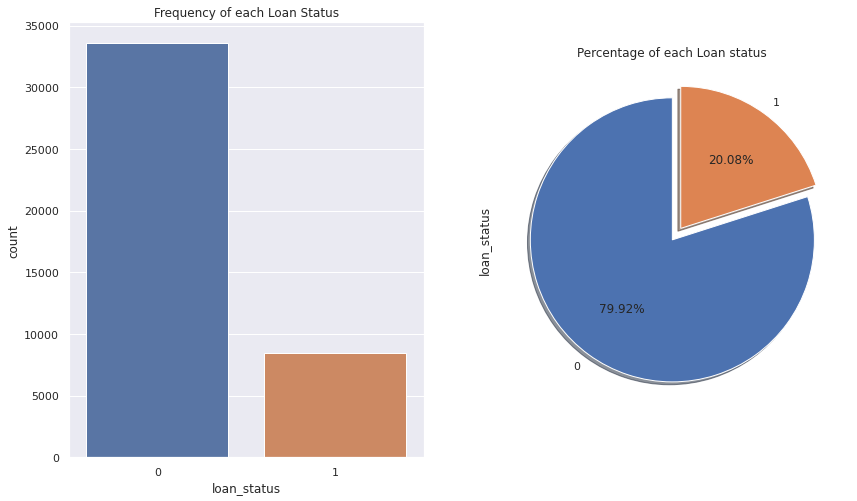

In [13]:
 sns.set_theme()
fig, axs = plt.subplots(1,2,figsize=(14,8))
sns.countplot(x='loan_status',data=loan_df,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
loan_df.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],shadow =True,explode = (0, 0.1,),autopct='%1.2f%%',startangle=90 )
axs[1].set_title("Percentage of each Loan status")
plt.show()

In [14]:
descr_df.dropna(inplace=True)

In [15]:
descr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   LoanStatNew  115 non-null    object
 1   Description  115 non-null    object
dtypes: object(2)
memory usage: 2.7+ KB


In [16]:
def missing_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [17]:
miss_values = missing_values(loan_df)
miss_values.head()

Dataframe has 115 columns.
There are 77 columns that have missing values.


,Missing Values,% of Total Values
total_cu_tl,42022,100.0
total_rev_hi_lim,42022,100.0
num_accts_ever_120_pd,42022,100.0
mths_since_recent_revol_delinq,42022,100.0
mths_since_recent_inq,42022,100.0


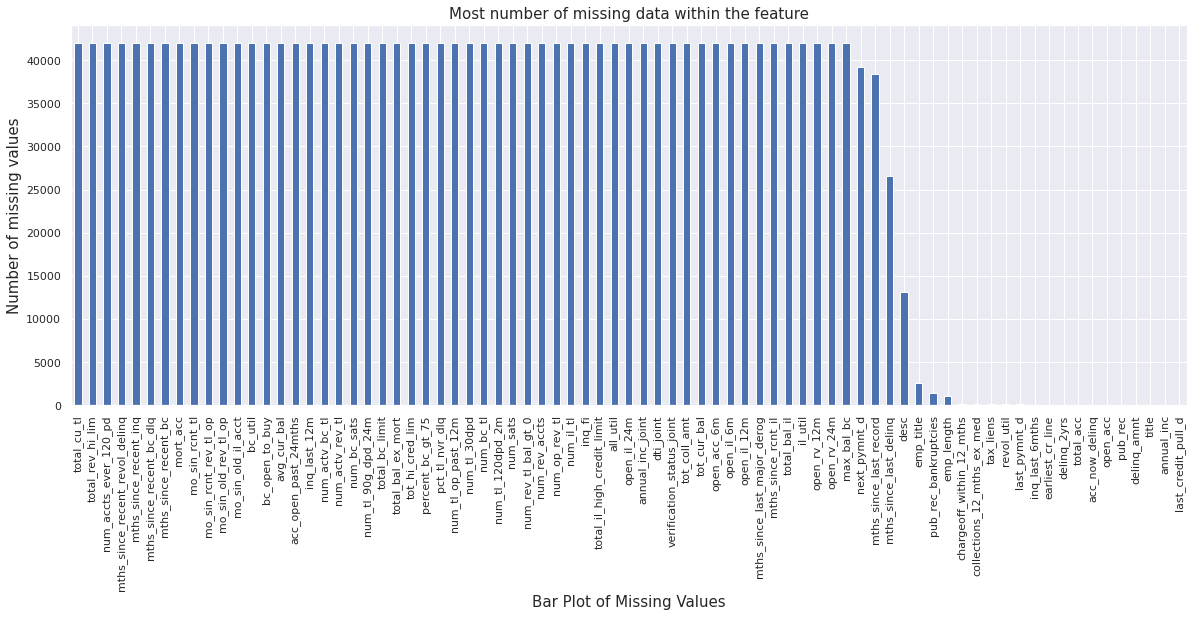

In [18]:
plt.figure(figsize=(20,7))
missing= loan_df.isnull().sum()
missing= missing[missing > 0]
missing.sort_values(ascending= False, inplace=True)
plt.xlabel("Bar Plot of Missing Values", fontsize=15)
plt.ylabel("Number of missing values", fontsize=15)
plt.title("Most number of missing data within the feature", fontsize=15)
missing[:80].plot(kind="bar")

plt.show()

In [19]:
columns = [column for column in loan_df.count() < 42022*0.10]
loan_df.drop(loan_df.columns[columns], axis=1, inplace=True)

In [20]:
miss_values = missing_values(loan_df)
miss_values.head()

Dataframe has 59 columns.
There are 21 columns that have missing values.


,Missing Values,% of Total Values
mths_since_last_delinq,26569,63.2
desc,13106,31.2
emp_title,2589,6.2
pub_rec_bankruptcies,1365,3.2
emp_length,1093,2.6


In [21]:
redundant_columns=list(loan_df.loc[:,loan_df.apply(pd.Series.nunique) == 1].columns)
len(redundant_columns)

5

In [22]:
loan_df = loan_df.loc[:,loan_df.apply(pd.Series.nunique) != 1]

In [23]:
miss_values = missing_values(loan_df)

Dataframe has 54 columns.
There are 19 columns that have missing values.


In [24]:
numeric_ls=list(loan_df.describe().columns.to_list())
loan_df[numeric_ls].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42022 entries, 0 to 42021
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   member_id                42022 non-null  float64
 1   loan_amnt                42022 non-null  float64
 2   funded_amnt              42022 non-null  float64
 3   funded_amnt_inv          42022 non-null  float64
 4   installment              42022 non-null  float64
 5   annual_inc               42018 non-null  float64
 6   loan_status              42022 non-null  int64  
 7   dti                      42022 non-null  float64
 8   delinq_2yrs              41993 non-null  float64
 9   fico_range_low           42022 non-null  float64
 10  fico_range_high          42022 non-null  float64
 11  inq_last_6mths           41993 non-null  float64
 12  mths_since_last_delinq   15453 non-null  float64
 13  open_acc                 41993 non-null  float64
 14  pub_rec               

In [25]:
loan_df[numeric_ls].head(2)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1296599.0,5000.0,5000.0,4975.0,162.87,24000.0,0,27.65,0.0,735.0,739.0,1.0,NaN,3.0,0.0,13648.0,9.0,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,171.62,744.0,740.0,0.0,0.0,0.0,0.0
1,1314167.0,2500.0,2500.0,2500.0,59.83,30000.0,1,1.00,0.0,740.0,744.0,5.0,NaN,3.0,0.0,1687.0,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,119.66,499.0,0.0,0.0,0.0,0.0,0.0


In [26]:
miss_values = missing_values(loan_df[numeric_ls])

Dataframe has 33 columns.
There are 11 columns that have missing values.


In [27]:
redundant_columns=['member_id','funded_amnt','funded_amnt_inv']
redundant_columns

['member_id', 'funded_amnt', 'funded_amnt_inv']

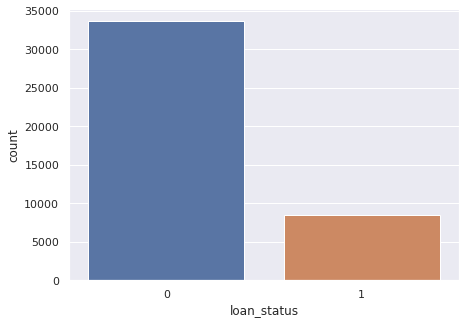

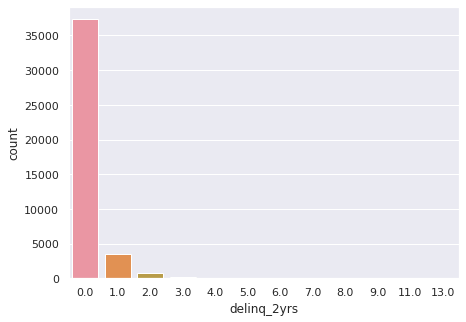

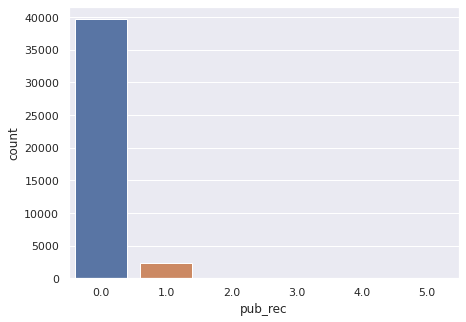

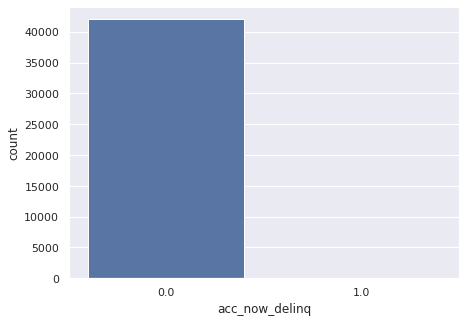

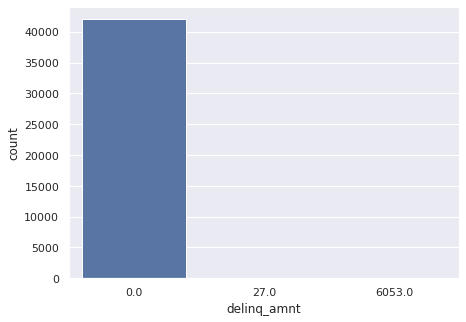

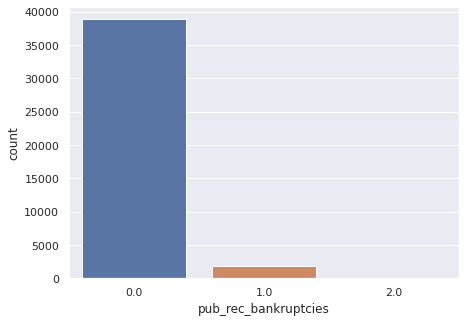

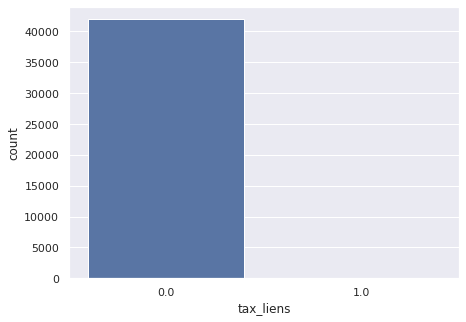

In [28]:
for column in numeric_ls:
  if loan_df[column].nunique() < 14:
    plt.figure(figsize=(7,5)) 
    sns.countplot(x=column,data=loan_df[numeric_ls])
    #plt.legend()
    plt.show()

In [29]:
redundant_columns.append('tax_liens')
redundant_columns.append('acc_now_delinq')
redundant_columns.append('delinq_amnt')
redundant_columns

['member_id',
 'funded_amnt',
 'funded_amnt_inv',
 'tax_liens',
 'acc_now_delinq',
 'delinq_amnt']

In [30]:
redundant_columns.extend(['total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
                         'collection_recovery_fee','out_prncp','out_prncp_inv','last_pymnt_amnt'])
print(redundant_columns)

['member_id', 'funded_amnt', 'funded_amnt_inv', 'tax_liens', 'acc_now_delinq', 'delinq_amnt', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'last_pymnt_amnt']


In [31]:
numeric_ls=list(set(numeric_ls)-set(redundant_columns))
print(numeric_ls)

['pub_rec', 'fico_range_high', 'installment', 'pub_rec_bankruptcies', 'revol_bal', 'loan_status', 'total_acc', 'last_fico_range_high', 'dti', 'mths_since_last_delinq', 'delinq_2yrs', 'last_fico_range_low', 'fico_range_low', 'loan_amnt', 'annual_inc', 'inq_last_6mths', 'open_acc']


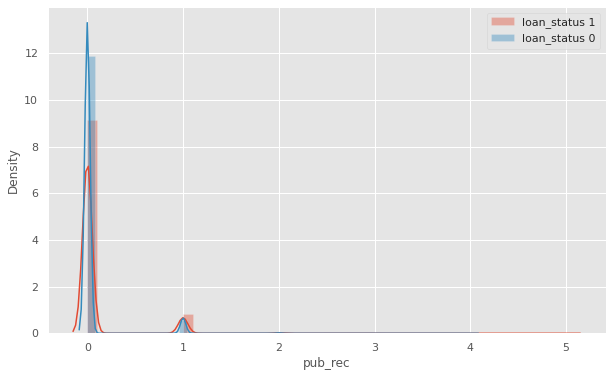

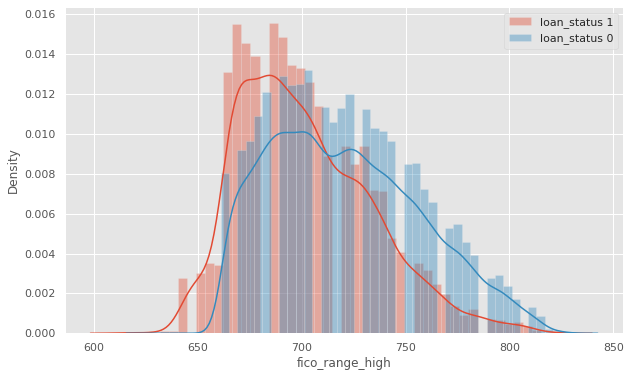

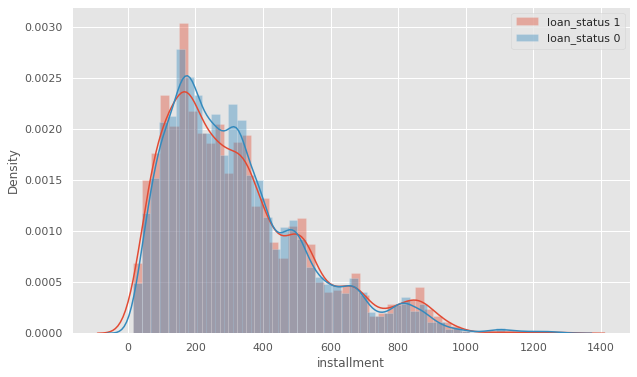

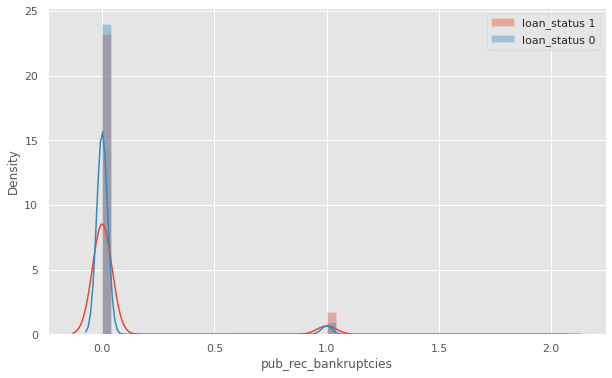

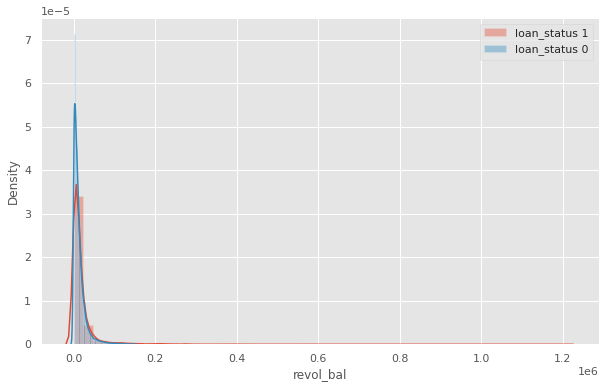

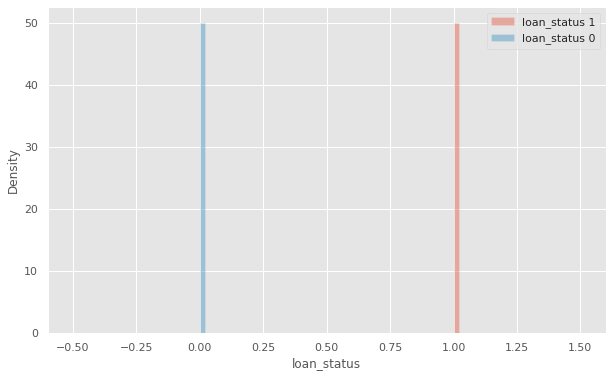

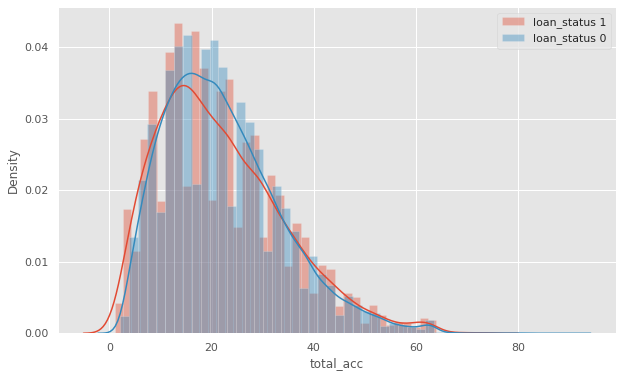

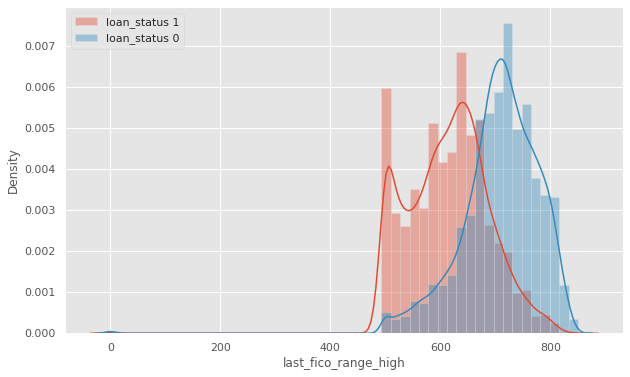

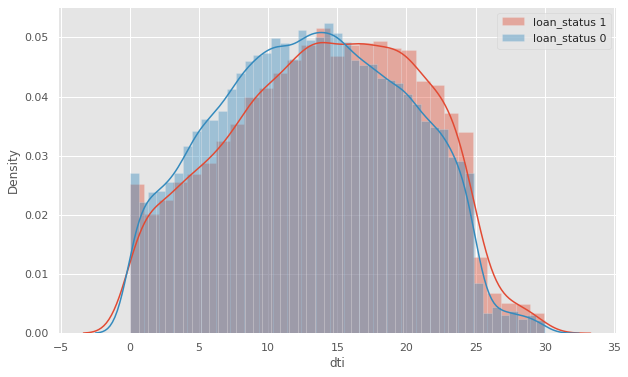

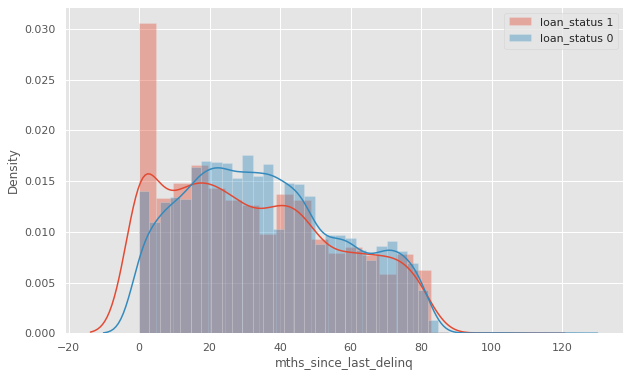

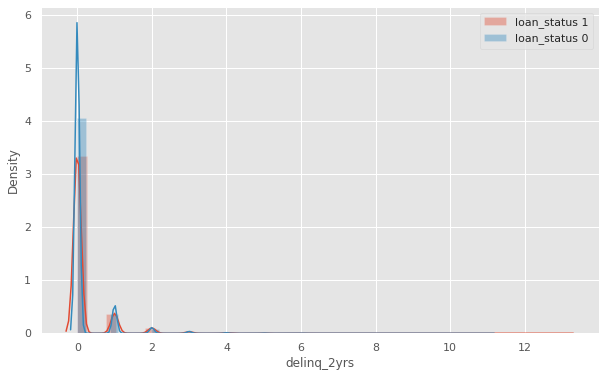

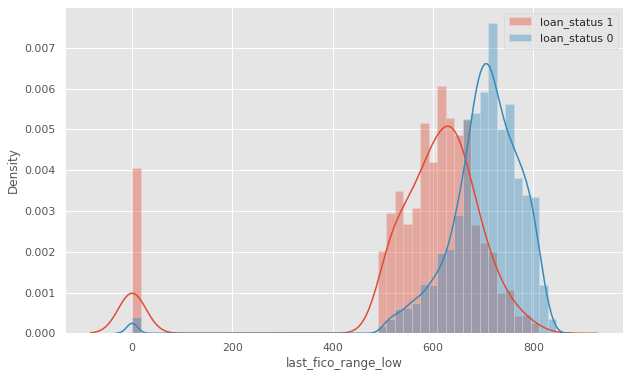

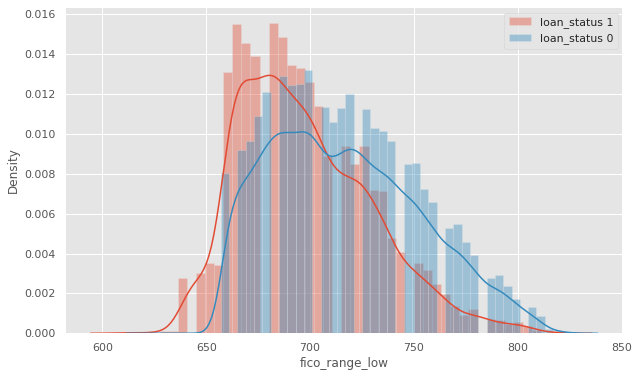

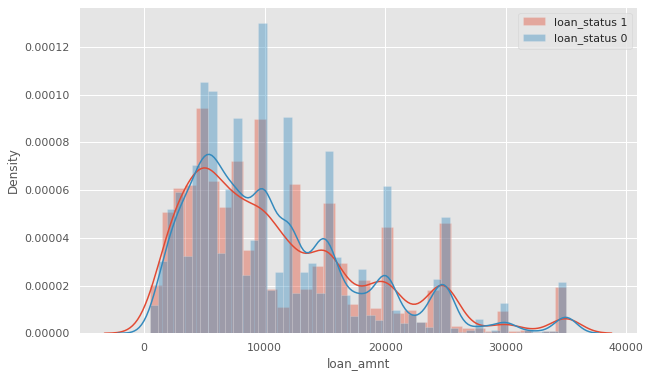

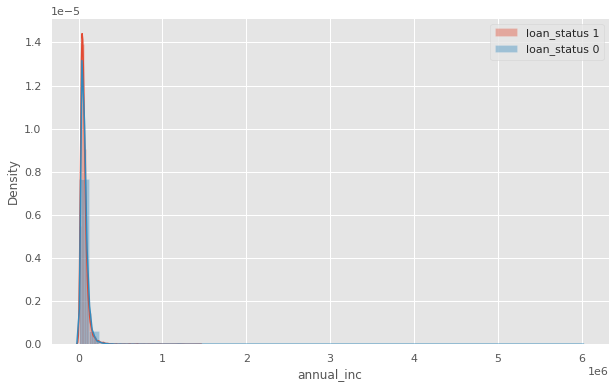

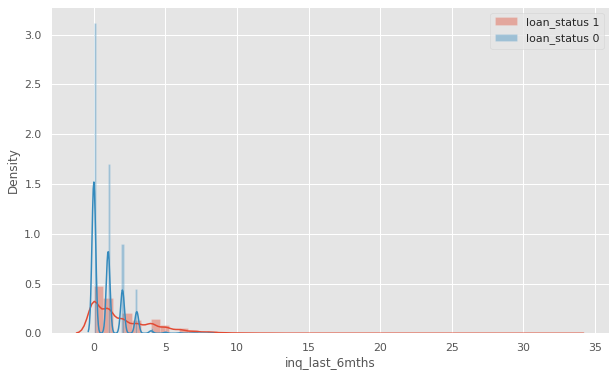

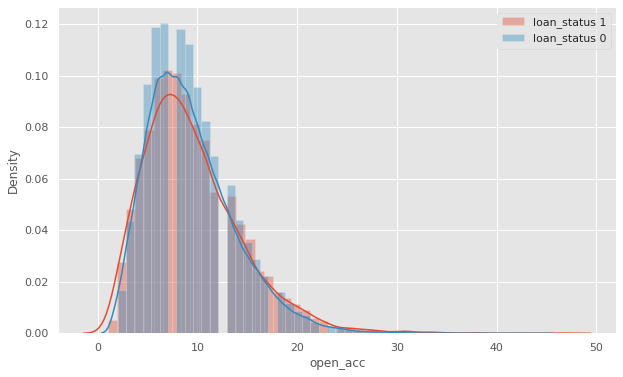

In [32]:
plt.style.use('ggplot')
for col in loan_df[numeric_ls].columns:
  fig = plt.figure(figsize=(10,6))
  plt.style.use('ggplot')
  sns.distplot(loan_df[numeric_ls].loc[loan_df['loan_status'] == 1, col],label='loan_status 1')
  sns.distplot(loan_df[numeric_ls].loc[loan_df['loan_status'] == 0, col],label='loan_status 0')
  plt.legend()
  plt.show()

In [33]:
loan_df[numeric_ls].head(3)

,pub_rec,fico_range_high,installment,pub_rec_bankruptcies,revol_bal,loan_status,total_acc,last_fico_range_high,dti,mths_since_last_delinq,delinq_2yrs,last_fico_range_low,fico_range_low,loan_amnt,annual_inc,inq_last_6mths,open_acc
0,0.0,739.0,162.87,0.0,13648.0,0,9.0,744.0,27.65,NaN,0.0,740.0,735.0,5000.0,24000.0,1.0,3.0
1,0.0,744.0,59.83,0.0,1687.0,1,4.0,499.0,1.00,NaN,0.0,0.0,740.0,2500.0,30000.0,5.0,3.0
2,0.0,739.0,84.33,0.0,2956.0,0,10.0,719.0,8.72,NaN,0.0,715.0,735.0,2400.0,12252.0,2.0,2.0


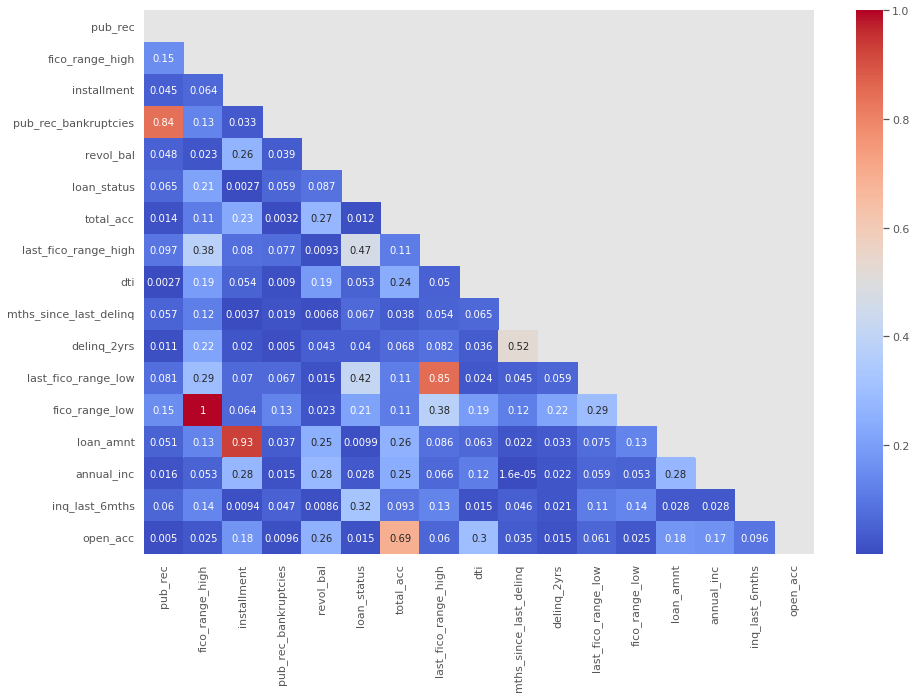

In [34]:
plt.figure(figsize=(15,10))
cor=loan_df[numeric_ls].corr().abs()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,mask=mask,annot=True,cmap='coolwarm')

In [35]:
loan_df[['fico_range_high','fico_range_low']].corr()

,fico_range_high,fico_range_low
fico_range_high,1.0,1.0
fico_range_low,1.0,1.0


In [36]:
loan_df['fico_range_avg']=(loan_df['fico_range_high']+loan_df['fico_range_low'])/2

In [37]:
redundant_columns.extend(['fico_range_low','fico_range_high'])
numeric_ls=list(set(numeric_ls)-set(redundant_columns))

In [38]:
categorical_ls=list(set(loan_df.columns.to_list())-set(loan_df.describe().columns.to_list()))
loan_df[categorical_ls].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42022 entries, 0 to 42021
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   42022 non-null  object
 1   revol_util           41932 non-null  object
 2   emp_title            39433 non-null  object
 3   last_pymnt_d         41939 non-null  object
 4   pymnt_plan           42022 non-null  object
 5   addr_state           42022 non-null  object
 6   title                42009 non-null  object
 7   desc                 28916 non-null  object
 8   sub_grade            42022 non-null  object
 9   int_rate             42022 non-null  object
 10  purpose              42022 non-null  object
 11  earliest_cr_line     41993 non-null  object
 12  zip_code             42022 non-null  object
 13  last_credit_pull_d   42018 non-null  object
 14  grade                42022 non-null  object
 15  term                 42022 non-null  object
 16  home

In [39]:
miss_values = missing_values(loan_df[categorical_ls])

Dataframe has 21 columns.
There are 8 columns that have missing values.


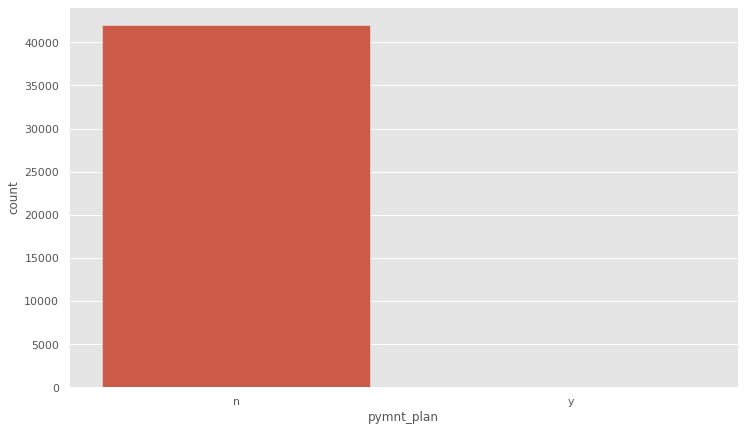

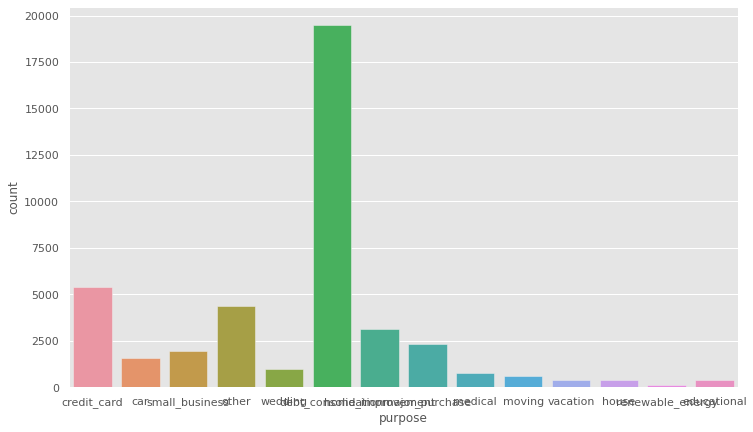

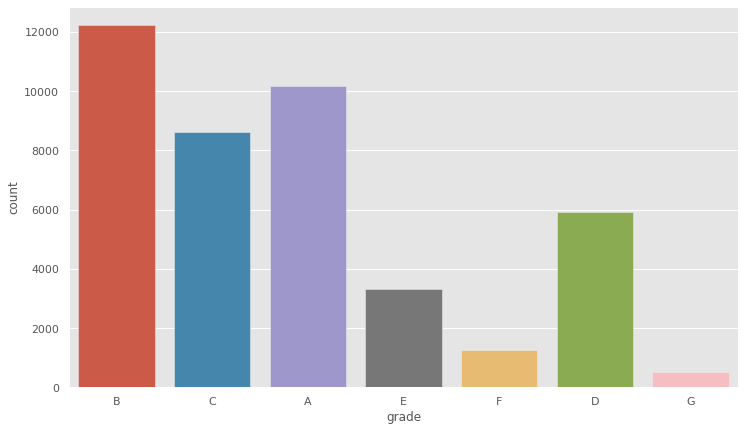

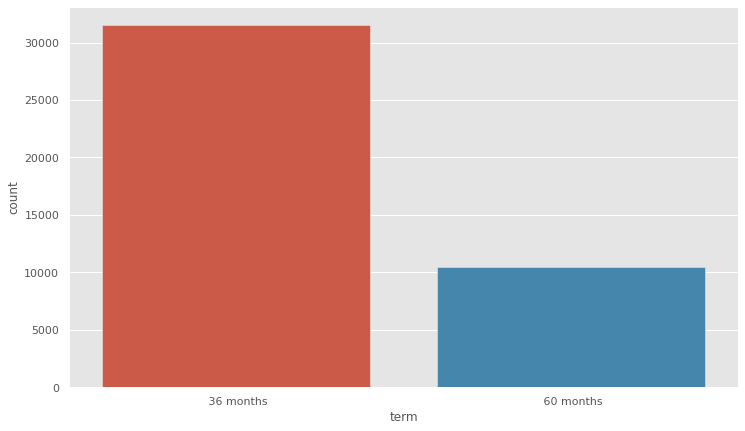

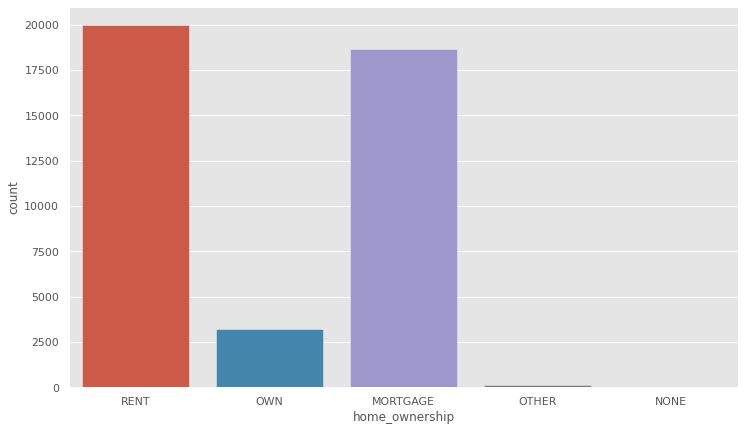

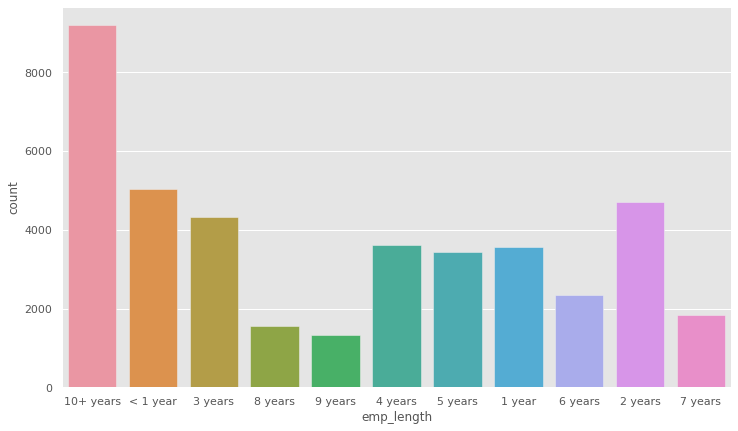

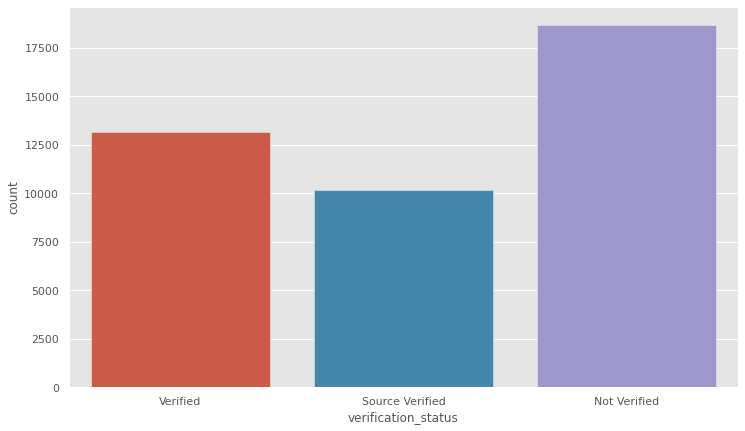

In [40]:
plt.style.use('ggplot')
for column in categorical_ls:
  if loan_df[column].nunique() < 25:
    plt.figure(figsize=(12,7)) 
    sns.countplot(x=column,data=loan_df[categorical_ls])
    #plt.legend()
    plt.show()

In [41]:

redundant_columns.extend(['last_pymnt_d','issue_d'])


In [42]:
redundant_columns.extend(['url','title','emp_title','pymnt_plan','desc','id'])

In [43]:
categorical_ls=list(set(categorical_ls)-set(redundant_columns))

In [44]:
loan_df['term'] = loan_df['term'].replace("months","", regex=True).astype(int)
loan_df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_df['emp_length']=loan_df['emp_length'].astype(float)

In [45]:
loan_df['int_rate'] = loan_df['int_rate'].replace("%","", regex=True).astype(float)

In [46]:
label_encod=['purpose','zip_code']

In [47]:
loan_df['earliest_cr_line_month'] = pd.to_datetime(loan_df['earliest_cr_line'].fillna('2001-08-01')).apply(lambda x: int(x.strftime('%m')))
loan_df['earliest_cr_line_year'] = pd.to_datetime(loan_df['earliest_cr_line'].fillna('2001-08-01')).apply(lambda x: int(x.strftime('%Y')))
redundant_columns.append('earliest_cr_line')

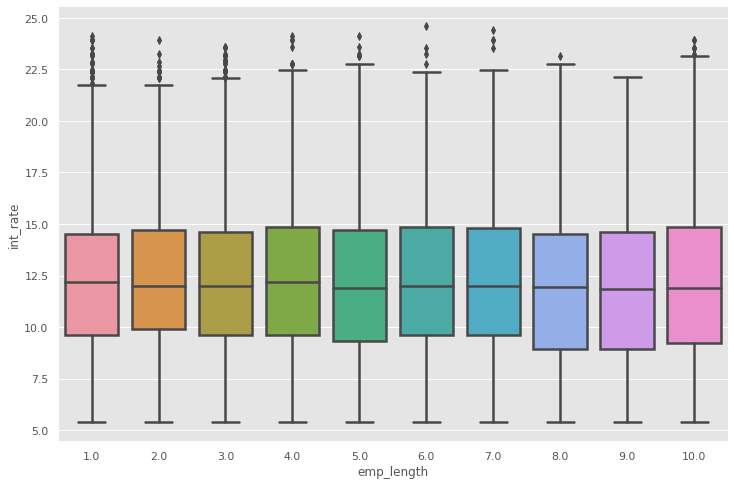

In [48]:
plt.figure(figsize = (12,8))
ax = sns.boxplot(x="emp_length" ,y= "int_rate", data=loan_df, linewidth=2.5)

plt.show()

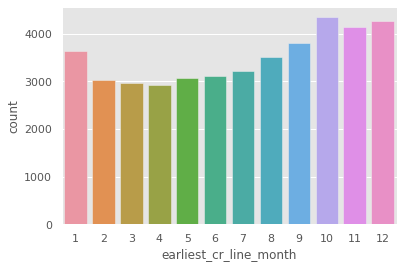

In [49]:
sns.countplot(x='earliest_cr_line_month',data=loan_df)

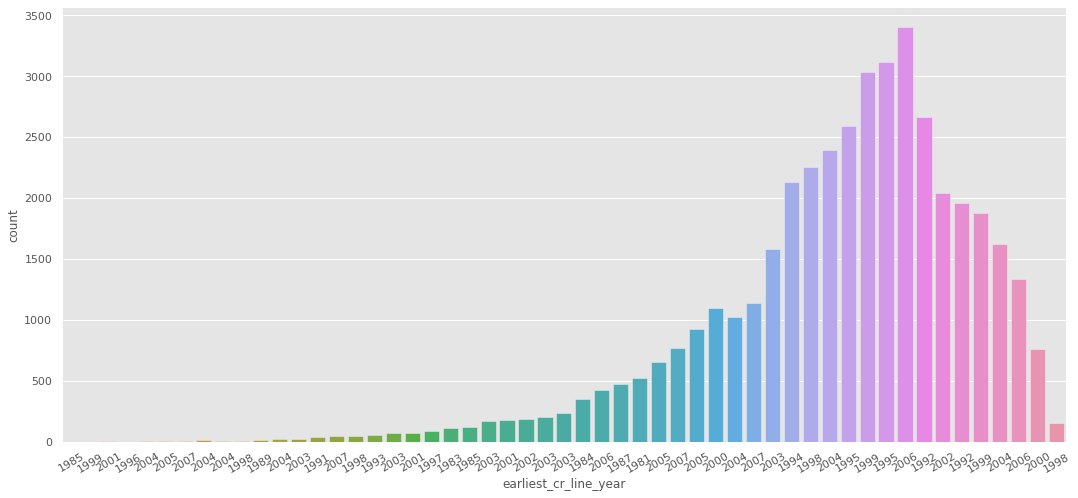

In [50]:
plt.figure(figsize=(18,8))
g=sns.countplot(x='earliest_cr_line_year',data=loan_df).set_xticklabels(labels=loan_df['earliest_cr_line_year'],rotation=30)


In [51]:
loan_df['last_credit_pull_d_month'] = pd.to_datetime(loan_df['last_credit_pull_d'].fillna('2016-09-01')).apply(lambda x: int(x.strftime('%m')))
loan_df['last_credit_pull_d_year'] = pd.to_datetime(loan_df['last_credit_pull_d'].fillna('2016-09-01')).apply(lambda x: int(x.strftime('%Y')))
redundant_columns.append('last_credit_pull_d')

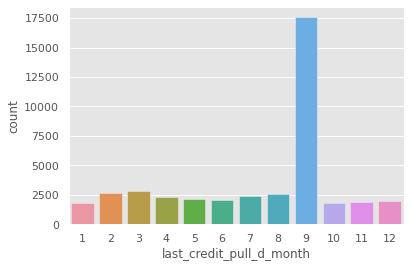

In [52]:
sns.countplot(x='last_credit_pull_d_month',data=loan_df)

In [53]:
one_hot_coding=['home_ownership']
redundant_columns.append('verification_status')

In [54]:
label_encod.append('grade')
label_encod.append('sub_grade')

label_encod.append('addr_state')

In [55]:
loan_df['revol_util'] = loan_df['revol_util'].str.replace('%', '')
loan_df['revol_util'] = loan_df['revol_util'].astype(float)

In [56]:
loan_df.drop(redundant_columns, axis=1, inplace=True)

In [57]:
label_encod

['purpose', 'zip_code', 'grade', 'sub_grade', 'addr_state']

In [58]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

loan_df[label_encod] =loan_df[label_encod].apply(LabelEncoder().fit_transform)

In [59]:
loan_df[label_encod].head(5)

,purpose,zip_code,grade,sub_grade,addr_state
0,1,726,1,6,3
1,0,280,2,13,10
2,11,512,2,14,14
3,9,763,2,10,4
4,13,720,0,3,3


In [60]:
#nominal_columns = ["purpose"]
dummy_df = pd.get_dummies(loan_df[one_hot_coding])
loan_df = pd.concat([loan_df, dummy_df], axis=1)
loan_df = loan_df.drop(one_hot_coding, axis=1)

In [61]:
loan_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,pub_rec_bankruptcies,fico_range_avg,earliest_cr_line_month,earliest_cr_line_year,last_credit_pull_d_month,last_credit_pull_d_year,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,5000.0,36,10.65,162.87,1,6,10.0,24000.0,0,1,726,3,27.65,0.0,1.0,NaN,3.0,0.0,13648.0,83.7,9.0,744.0,740.0,0.0,1474.0,1,1985,9,2016,0,0,0,0,1
1,2500.0,60,15.27,59.83,2,13,1.0,30000.0,1,0,280,10,1.00,0.0,5.0,NaN,3.0,0.0,1687.0,9.4,4.0,499.0,0.0,0.0,1484.0,4,1999,9,2016,0,0,0,0,1
2,2400.0,36,15.96,84.33,2,14,10.0,12252.0,0,11,512,14,8.72,0.0,2.0,NaN,2.0,0.0,2956.0,98.5,10.0,719.0,715.0,0.0,1474.0,11,2001,9,2016,0,0,0,0,1
3,10000.0,36,13.49,339.31,2,10,10.0,49200.0,0,9,763,4,20.00,0.0,1.0,35.0,10.0,0.0,5598.0,21.0,37.0,604.0,600.0,0.0,1384.0,2,1996,4,2016,0,0,0,0,1
4,5000.0,36,7.90,156.46,0,3,3.0,36000.0,0,13,720,3,11.20,0.0,3.0,NaN,9.0,0.0,7963.0,28.3,12.0,679.0,675.0,0.0,1464.0,11,2004,1,2016,0,0,0,0,1


In [62]:
redundant_columns.append('home_ownership_NONE')

In [63]:
loan_df.shape

(42022, 34)

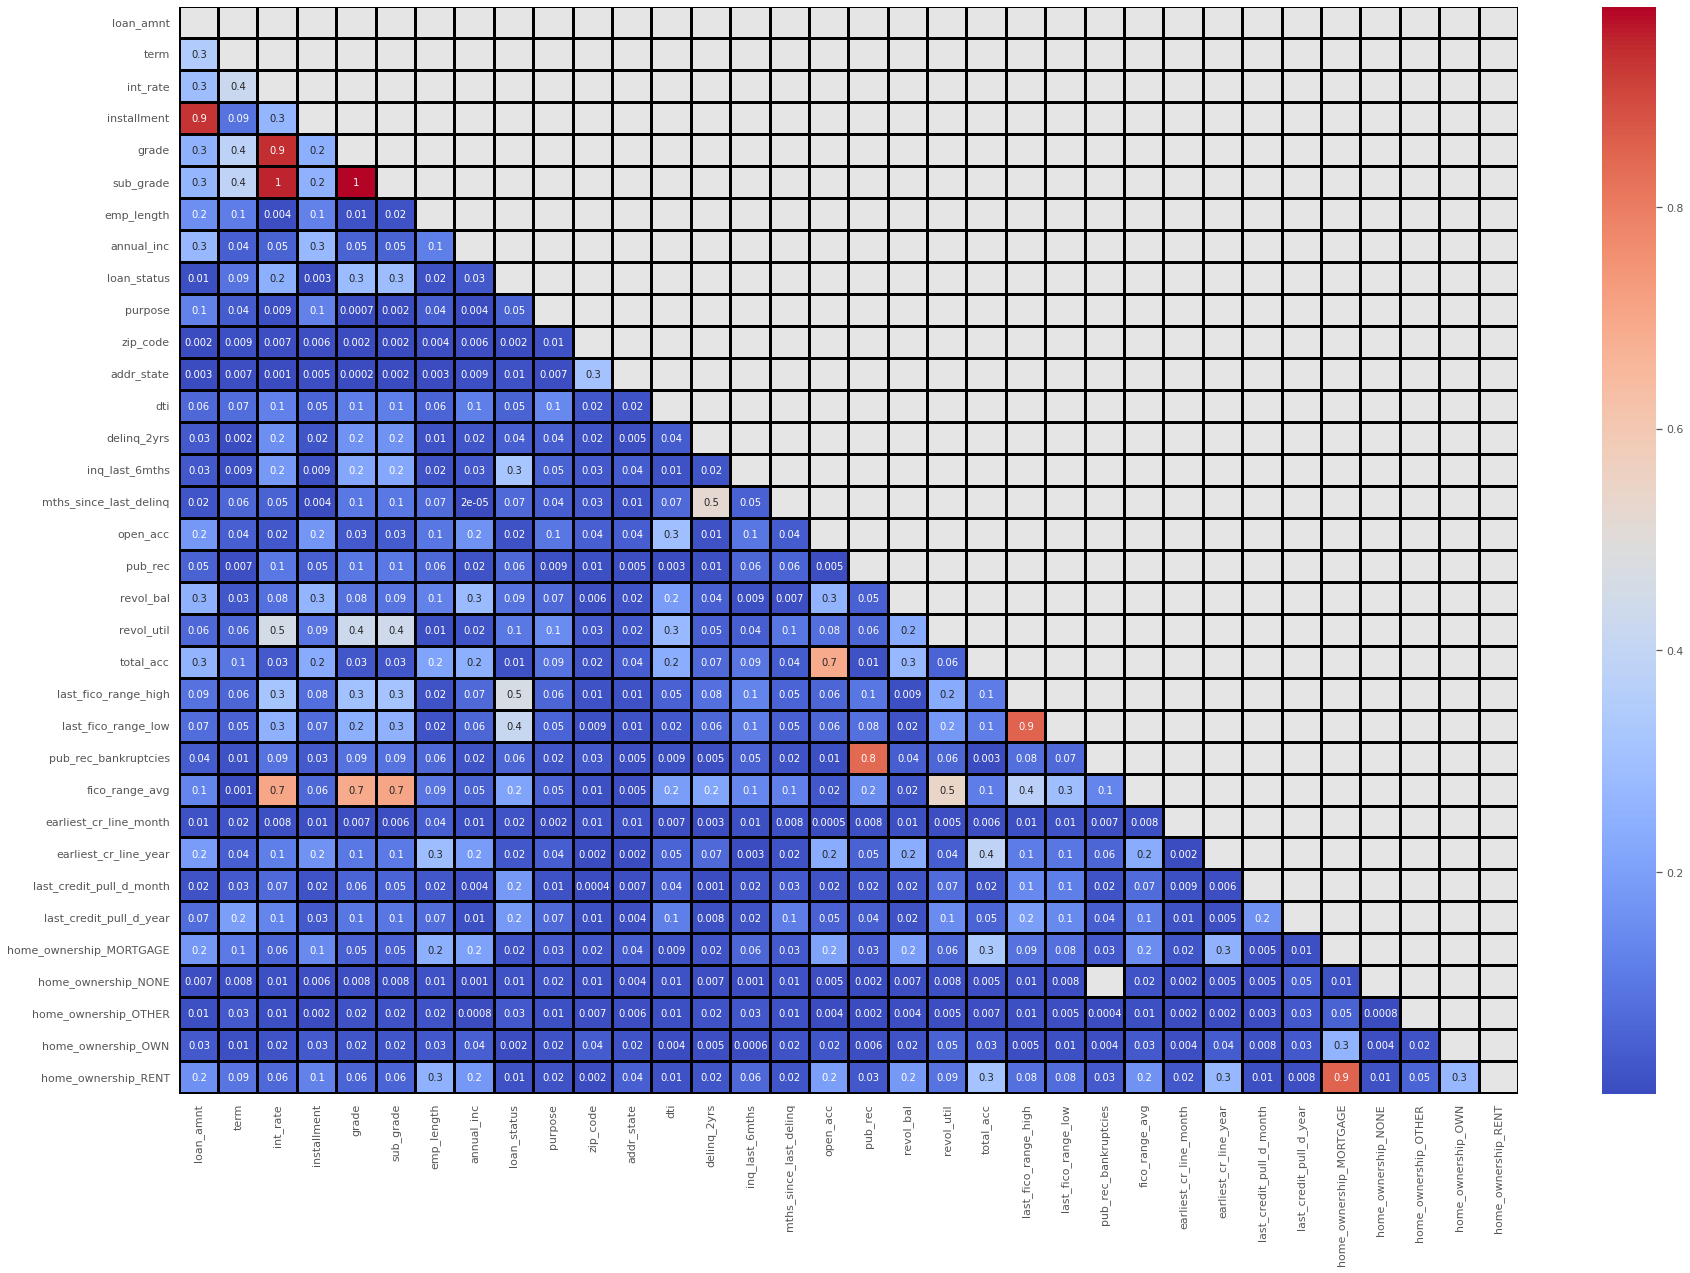

In [64]:
plt.figure(figsize=(30,20))
cor=loan_df.corr().abs()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,mask=mask, annot=True, cmap='coolwarm',fmt='.1g' ,linewidths=2, linecolor='black',)

In [65]:
loan_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'last_fico_range_high',
       'last_fico_range_low', 'pub_rec_bankruptcies', 'fico_range_avg',
       'earliest_cr_line_month', 'earliest_cr_line_year',
       'last_credit_pull_d_month', 'last_credit_pull_d_year',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

In [66]:
miss_values=missing_values(loan_df)
miss_values.head()

Dataframe has 34 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
mths_since_last_delinq,26569,63.2
pub_rec_bankruptcies,1365,3.2
emp_length,1093,2.6
revol_util,90,0.2
delinq_2yrs,29,0.1


In [67]:
null_valued_cols=loan_df.isna().sum()[loan_df.isna().sum()!=0].index.to_list()

In [68]:
cat_null=[i for i in null_valued_cols if i in categorical_ls]
cat_null

['emp_length', 'revol_util']

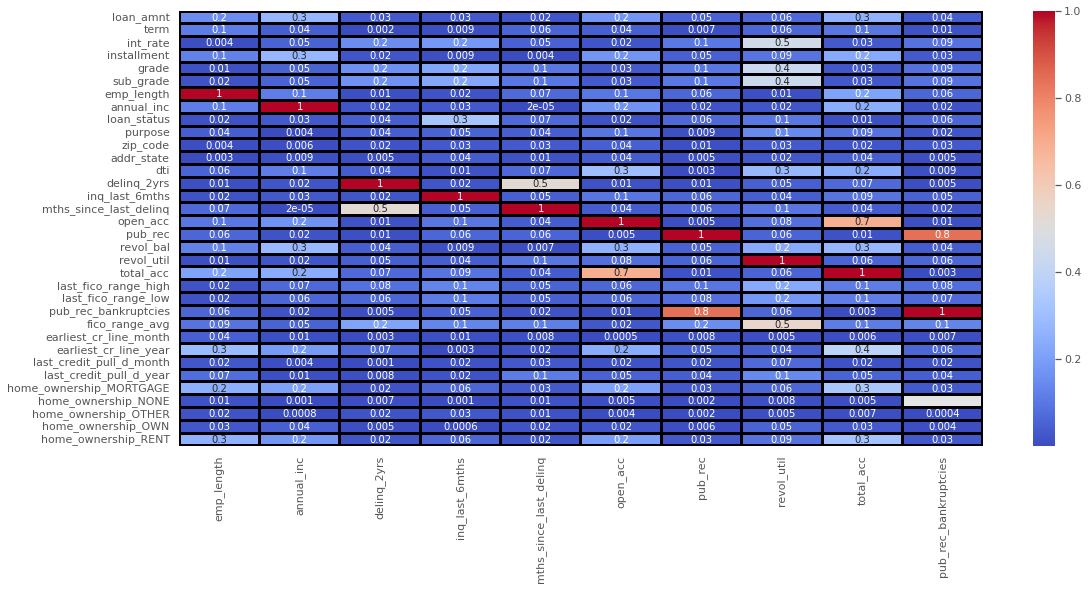

In [69]:

plt.figure(figsize=(18,8))
cor=loan_df.corr()[null_valued_cols].abs()

sns.heatmap(cor,annot=True, cmap='coolwarm',fmt='.1g' ,linewidths=2, linecolor='black',)

In [70]:
X=loan_df.values

In [71]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')

In [72]:
X=loan_df.values
imputer.fit(X)

KNNImputer(n_neighbors=3)

In [73]:
Xtrans = imputer.transform(X)

In [74]:
Xtrans.shape

(42022, 34)

In [75]:
loan_df=pd.DataFrame(Xtrans,columns=loan_df.columns.to_list())

In [76]:
loan_df=pd.DataFrame(Xtrans,columns=loan_df.columns.to_list())
X=loan_df.drop(columns=['loan_status']).values
y=loan_df.loan_status

In [77]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)

In [78]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [79]:
principalDf['loan_status']=y

In [81]:
loan_df[cat_null]=loan_df[cat_null].round()

In [82]:
X=loan_df.drop(columns=['loan_status'])
y=loan_df.loan_status

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

In [84]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31516, 33), (10506, 33), (31516,), (10506,))

In [85]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

In [86]:
from sklearn import metrics
from sklearn.metrics import classification_report,recall_score,accuracy_score,precision_score

def Model_performance(model,X_train,X_test, y_train,y_test):
        #Train
        model.fit(X_train,y_train)
        train_class_preds =model.predict(X_train)
        print()
        train_accuracy=model.score(X_train,y_train)
        precision_train=metrics.precision_score(y_train,train_class_preds)
        recall_train=metrics.recall_score(y_train,train_class_preds)
        f1_train=metrics.f1_score(y_train,train_class_preds)
        fp_train, tp_train, th_train = metrics.roc_curve(y_train,train_class_preds)
        auc_train=metrics.auc(fp_train, tp_train)
        classification_report_train=classification_report(y_train,train_class_preds)
        cm_train = confusion_matrix(y_train, train_class_preds)

        #Test
        test_class_preds = model.predict(X_test)
        test_accuracy=model.score(X_test,y_test)
        precision_test=metrics.precision_score(y_test,test_class_preds)
        recall_test=metrics.recall_score(y_test,test_class_preds)
        f1_test=metrics.f1_score(y_test,test_class_preds)
        fp, tp, th = metrics.roc_curve(y_test, test_class_preds)
        auc_test=metrics.auc(fp, tp)
        classification_report_test=classification_report(y_test,test_class_preds)
        cm_test = confusion_matrix(y_test,test_class_preds)
        evaluation={'test_accuracy':test_accuracy,'recall_test':recall_test,'precision_test':precision_test,
                     'f1_test':f1_test,'auc_test':auc_test,"cm_test":cm_test,'train_accuracy':train_accuracy,
                     'precision_train':precision_train,'recall_train':recall_train,'f1_train':f1_train,
                    'auc_train':auc_train,'cm_train':cm_train}
        return evaluation

In [87]:
logistic_met=Model_performance(lr,X_train,X_test, y_train,y_test)
print(logistic_met)


{'test_accuracy': 0.8320959451741862, 'recall_test': 0.3309557774607703, 'precision_test': 0.6609686609686609, 'f1_test': 0.44106463878326996, 'auc_test': 0.644235475306608, 'cm_test': array([[8046,  357],
       [1407,  696]]), 'train_accuracy': 0.8311651224774718, 'precision_train': 0.6622835150737653, 'recall_train': 0.32606979314700774, 'f1_train': 0.4369907946249075, 'auc_train': 0.6421279355283545, 'cm_train': array([[24130,  1053],
       [ 4268,  2065]])}


In [88]:

Eval_df=pd.DataFrame.from_dict(logistic_met, orient='index',columns=['Logistic Regression'])
Eval_df

,Logistic Regression
test_accuracy,0.832096
recall_test,0.330956
precision_test,0.660969
f1_test,0.441065
auc_test,0.644235
cm_test,"[[8046, 357], [1407, 696]]"
train_accuracy,0.831165
precision_train,0.662284
recall_train,0.32607
f1_train,0.436991


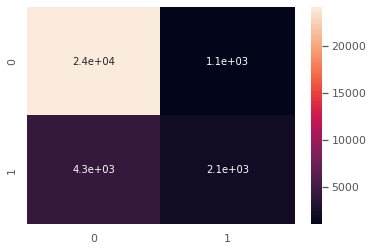

In [89]:
sns.heatmap(Eval_df['Logistic Regression']['cm_train'],annot=True)

In [90]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [91]:
std=StandardScaler()
X_train=std.fit_transform(X_train)
X_test=std.fit_transform(X_test)

In [92]:
from sklearn.model_selection import GridSearchCV

In [93]:
# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

In [94]:
Svm_eval=Model_performance(svc_model,X_train,X_test, y_train,y_test)

In [95]:
sv_df=pd.DataFrame.from_dict(Svm_eval, orient='index',columns=['SVMs'])
sv_df

,SVMs
test_accuracy,0.868646
recall_test,0.904898
precision_test,0.617256
f1_test,0.733899
auc_test,0.882236
cm_test,"[[7223, 1180], [200, 1903]]"
train_accuracy,0.890849
precision_train,0.659499
recall_train,0.944418
f1_train,0.776652


In [96]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [97]:
# fit predictor and target variable
x_smote,y_smote  = smote.fit_resample(X_train, y_train)
x_smote=pd.DataFrame(x_smote,columns=loan_df.drop('loan_status',axis=1).columns.to_list())
X_test=pd.DataFrame(X_test,columns=loan_df.drop('loan_status',axis=1).columns.to_list())
y_smote=pd.Series(y_smote)

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score,recall_score,accuracy_score,roc_auc_score,roc_curve,confusion_matrix,auc,r2_score,f1_score

In [99]:
lr_model=LogisticRegression(C=0.01,penalty='l1',max_iter=200,solver='liblinear')
dt_model=DecisionTreeClassifier()
rf_model=RandomForestClassifier()
gbc_model=GradientBoostingClassifier()
xgb_model=XGBClassifier()
knn_model = KNeighborsClassifier()
svm_model = SVC()

models=[lr_model,dt_model,rf_model,gbc_model,xgb_model,knn_model,svm_model]

dct_train={}
dct_test={}
lst_imp=[]
def score_model(X_train,y_train,X_test,y_test):
    df_columns=[]
    df=pd.DataFrame(columns=df_columns)
    i=0
    for model in models:
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        y_pred_train=model.predict(X_train)
        
        
        train_accuracy=accuracy_score(y_train,y_pred_train)
        test_accuracy=accuracy_score(y_test,y_pred)
        p_score_train=precision_score(y_train,y_pred_train)
        p_score=precision_score(y_test,y_pred)
        r_score_train=recall_score(y_train,y_pred_train)
        r_score=recall_score(y_test,y_pred)
        train_auc = roc_auc_score(y_train,y_pred_train)
        test_auc = roc_auc_score(y_test,y_pred)
        fp, tp, th = roc_curve(y_test, y_pred)
        fptrain, tptrain, th_train = roc_curve(y_train, y_pred_train)
        
        
        df.loc[i,"Model Name"]=model.__class__.__name__
        df.loc[i,"Train Accuracy"]=round(train_accuracy,2)
        df.loc[i,"Test Accuracy"]=round(test_accuracy,2)
        df.loc[i,"Precision Train"]=round(p_score_train,2)
        df.loc[i,"Precision Test"]=round(p_score,2)
        df.loc[i,"Recall Train"]=round(r_score_train,2)
        df.loc[i,"Recall test"]=round(r_score,2)
        df.loc[i,"ROC AUC Train"]=round(train_auc,2)
        df.loc[i,"ROC AUC Test"]=round(test_auc,2)
        df.loc[i,'AUC Train'] = auc(fptrain, tptrain)
        df.loc[i,'AUC Test'] = auc(fp, tp)
        #inserted in dictionary
        dct_train[model.__class__.__name__]=confusion_matrix(y_train,y_pred_train)
        dct_test[model.__class__.__name__]=confusion_matrix(y_test,y_pred)

        i+=1
    
    return df,dct_train,dct_test

In [100]:
result_df,dct_train,dct_test=score_model(x_smote,y_smote,X_test,y_test)

In [101]:
result_df

,Model Name,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall test,ROC AUC Train,ROC AUC Test,AUC Train,AUC Test
0,LogisticRegression,0.84,0.83,0.83,0.54,0.85,0.83,0.84,0.83,0.840110,0.828662
1,DecisionTreeClassifier,1.00,0.69,1.00,0.38,1.00,0.89,1.00,0.77,1.000000,0.765500
2,RandomForestClassifier,1.00,0.78,1.00,0.47,1.00,0.95,1.00,0.84,1.000000,0.842818
3,GradientBoostingClassifier,0.93,0.72,0.92,0.41,0.95,0.97,0.93,0.81,0.934480,0.811869
4,XGBClassifier,0.93,0.70,0.92,0.40,0.95,0.97,0.93,0.80,0.934241,0.800327
5,KNeighborsClassifier,0.91,0.79,0.86,0.48,0.99,0.82,0.91,0.80,0.913533,0.797551
6,SVC,0.93,0.88,0.90,0.64,0.96,0.88,0.93,0.88,0.925783,0.875468


In [102]:
for key,value in dct_test.items():
  print(f'For {key} Confusion matrix is :')
  print(value)

For LogisticRegression Confusion matrix is :
[[6914 1489]
 [ 348 1755]]
For DecisionTreeClassifier Confusion matrix is :
[[5393 3010]
 [ 233 1870]]
For RandomForestClassifier Confusion matrix is :
[[6141 2262]
 [  95 2008]]
For GradientBoostingClassifier Confusion matrix is :
[[5501 2902]
 [  65 2038]]
For XGBClassifier Confusion matrix is :
[[5319 3084]
 [  68 2035]]
For KNeighborsClassifier Confusion matrix is :
[[6531 1872]
 [ 383 1720]]
For SVC Confusion matrix is :
[[7357 1046]
 [ 262 1841]]


For LogisticRegression Confusion matrix HeatMap is :


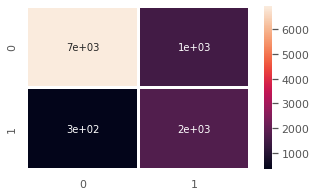

For DecisionTreeClassifier Confusion matrix HeatMap is :


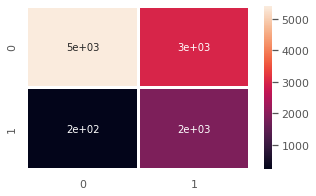

For RandomForestClassifier Confusion matrix HeatMap is :


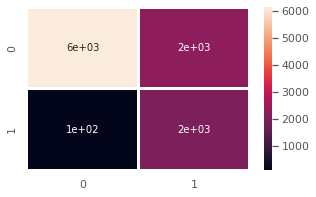

For GradientBoostingClassifier Confusion matrix HeatMap is :


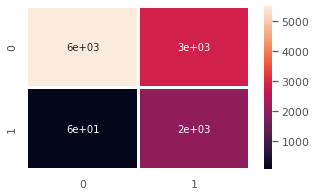

For XGBClassifier Confusion matrix HeatMap is :


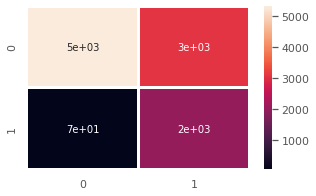

For KNeighborsClassifier Confusion matrix HeatMap is :


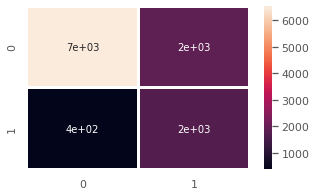

For SVC Confusion matrix HeatMap is :


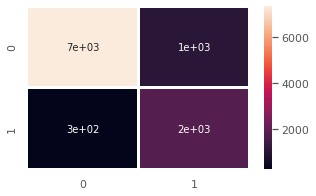

In [103]:
for key,value in dct_test.items():
  print(f'For {key} Confusion matrix HeatMap is :')
  plt.figure(figsize=(5,3))
  sns.heatmap(data=value,annot=True,fmt='.1g' ,linewidths=2)
  plt.show()

In [104]:
for key,value in dct_train.items():
  print(f'For {key} Confusion matrix is :')
  print(value)

For LogisticRegression Confusion matrix is :
[[20803  4380]
 [ 3673 21510]]
For DecisionTreeClassifier Confusion matrix is :
[[25183     0]
 [    0 25183]]
For RandomForestClassifier Confusion matrix is :
[[25183     0]
 [    0 25183]]
For GradientBoostingClassifier Confusion matrix is :
[[23212  1971]
 [ 1329 23854]]
For XGBClassifier Confusion matrix is :
[[23192  1991]
 [ 1321 23862]]
For KNeighborsClassifier Confusion matrix is :
[[20989  4194]
 [  161 25022]]
For SVC Confusion matrix is :
[[22521  2662]
 [ 1076 24107]]


For LogisticRegression Confusion matrix HeatMap is :


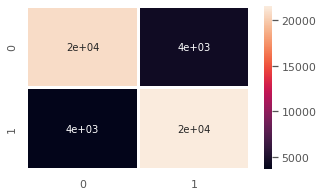

For DecisionTreeClassifier Confusion matrix HeatMap is :


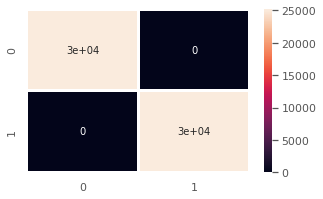

For RandomForestClassifier Confusion matrix HeatMap is :


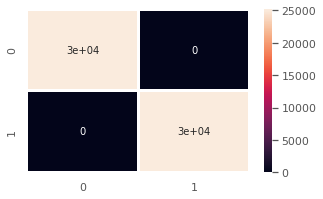

For GradientBoostingClassifier Confusion matrix HeatMap is :


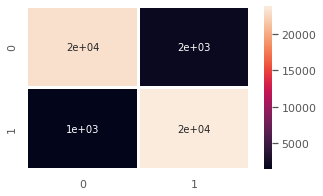

For XGBClassifier Confusion matrix HeatMap is :


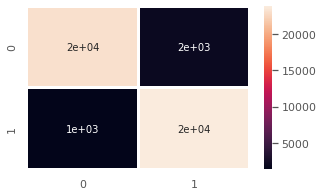

For KNeighborsClassifier Confusion matrix HeatMap is :


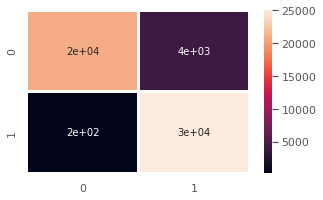

For SVC Confusion matrix HeatMap is :


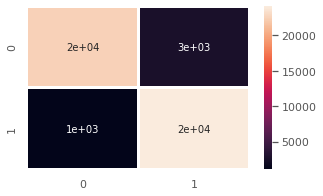

In [105]:
for key,value in dct_train.items():
  print(f'For {key} Confusion matrix HeatMap is :')
  plt.figure(figsize=(5,3))
  sns.heatmap(data=value,annot=True,fmt='.1g' ,linewidths=2)
  plt.show()

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

In [107]:
# Applying gridsearch cv 
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,n_estimators=60, max_features='sqrt',
                                                               subsample=0.8, random_state=10), 
                        param_grid = param_test2, scoring='roc_auc',n_jobs=-1, cv=5)

In [108]:
gsearch_met=Model_performance(gsearch,X_train,X_test, y_train,y_test)
print(gsearch_met)


{'test_accuracy': 0.9671459862312832, 'recall_test': 0.8055159296243461, 'precision_test': 0.8113026819923371, 'f1_test': 0.8083989501312335, 'auc_test': 0.879313956719825, 'cm_test': array([[8009,  394],
       [ 409, 1694]]), 'train_accuracy': 0.9901917145399827, 'precision_train': 0.8911468178954002, 'recall_train': 0.8932575398705195, 'f1_train': 0.8922009305259838, 'auc_train': 0.932909197207626, 'cm_train': array([[24492,   691],
       [  676,  5657]])}


In [109]:
gsearch_met_df=pd.DataFrame.from_dict(gsearch_met, orient='index',columns=['Grad_Boost'])
gsearch_met_df

,Grad_Boost
test_accuracy,0.967146
recall_test,0.805516
precision_test,0.811303
f1_test,0.808399
auc_test,0.879314
cm_test,"[[8009, 394], [409, 1694]]"
train_accuracy,0.990192
precision_train,0.891147
recall_train,0.893258
f1_train,0.892201


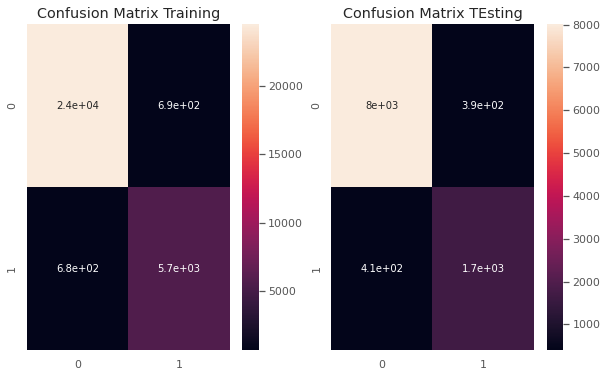

In [110]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].set_title("Confusion Matrix Training")
sns.heatmap(gsearch_met_df['Grad_Boost']['cm_train'],annot=True,ax=axs[0])
axs[1].set_title("Confusion Matrix TEsting")
sns.heatmap(gsearch_met_df['Grad_Boost']['cm_test'],annot=True,ax=axs[1])


In [111]:
from sklearn.metrics import roc_curve,precision_recall_curve,plot_roc_curve

In [112]:
from sklearn.metrics import classification_report

In [113]:
n_estimators = [100, 30, 50, 800, 120]
max_depth = [5, 8, 15, 25]
min_samples_split = [20,10,  15, 100]
min_samples_leaf = [ 2, 5, 10] 
forest = RandomForestClassifier(random_state = 1)
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
RandomForest_Eval = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


In [114]:
RForest_Eval=RandomForest_Eval.best_estimator_

In [115]:
RForest_Eval

RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=800, random_state=1)

In [116]:
y_pred=RForest_Eval.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))

[[8004  399]
 [ 402 1701]]
Accuracy Score 0.9237578526556254
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      8403
         1.0       0.81      0.81      0.81      2103

    accuracy                           0.92     10506
   macro avg       0.88      0.88      0.88     10506
weighted avg       0.92      0.92      0.92     10506



In [117]:
from sklearn.model_selection import RandomizedSearchCV
xgb= XGBClassifier(scale_pos_weight=90,objective = 'binary:logistic',
    nthread=4,
    eta = 0.1,
    num_boost_round = 80,
    max_depth = 5,
    subsample = 0.5,
    colsample_bytree = 1.0,
    silent = 1,
    )

parameters = {
    'weights' :[ 99, 75, ],
    'num_boost_round': [10, 25,],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}


grid = RandomizedSearchCV(xgb, parameters, cv=2, scoring='roc_auc')

In [118]:
XgbEval=grid.fit(X_train, y_train)

In [119]:
best_prams=XgbEval.best_estimator_
best_prams

XGBClassifier(colsample_bytree=0.9, eta=0.05, max_depth=4, nthread=4,
              num_boost_round=10, scale_pos_weight=90, silent=1, subsample=0.9,
              weights=99)

In [136]:
xgsearch_met=Model_performance(grid,X_train,X_test, y_train,y_test)
print(xgsearch_met)


{'test_accuracy': 0.9621867040330284, 'recall_test': 0.9852591535901094, 'precision_test': 0.4252000820849579, 'f1_test': 0.5940366972477064, 'auc_test': 0.8259629101283881, 'cm_test': array([[5602, 2801],
       [  31, 2072]]), 'train_accuracy': 0.9710759275891724, 'precision_train': 0.430644501975746, 'recall_train': 0.9981051634296542, 'f1_train': 0.601684831754795, 'auc_train': 0.8331271558322872, 'cm_train': array([[16826,  8357],
       [   12,  6321]])}


In [120]:
y_pred=best_prams.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))

[[4871 3532]
 [  22 2081]]
Accuracy Score 0.661717114030078
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.73      8403
         1.0       0.37      0.99      0.54      2103

    accuracy                           0.66     10506
   macro avg       0.68      0.78      0.64     10506
weighted avg       0.87      0.66      0.69     10506



In [122]:
from sklearn.metrics import precision_recall_curve
y_scores = best_prams.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)

In [137]:
import sklearn.metrics

auprc = sklearn.metrics.average_precision_score(y_train, y_scores)
print(auprc)

0.876263791916815


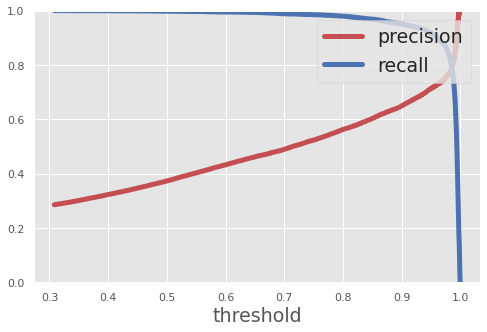

In [123]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 5))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

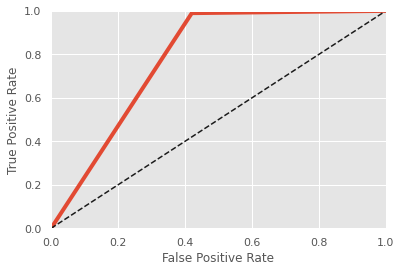

In [124]:
fpr,tpr,thresholds=roc_curve(y_test,y_pred)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=4,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr,tpr)
plt.show()

In [125]:
features = X.columns
importances = best_prams.feature_importances_
indices = np.argsort(importances)

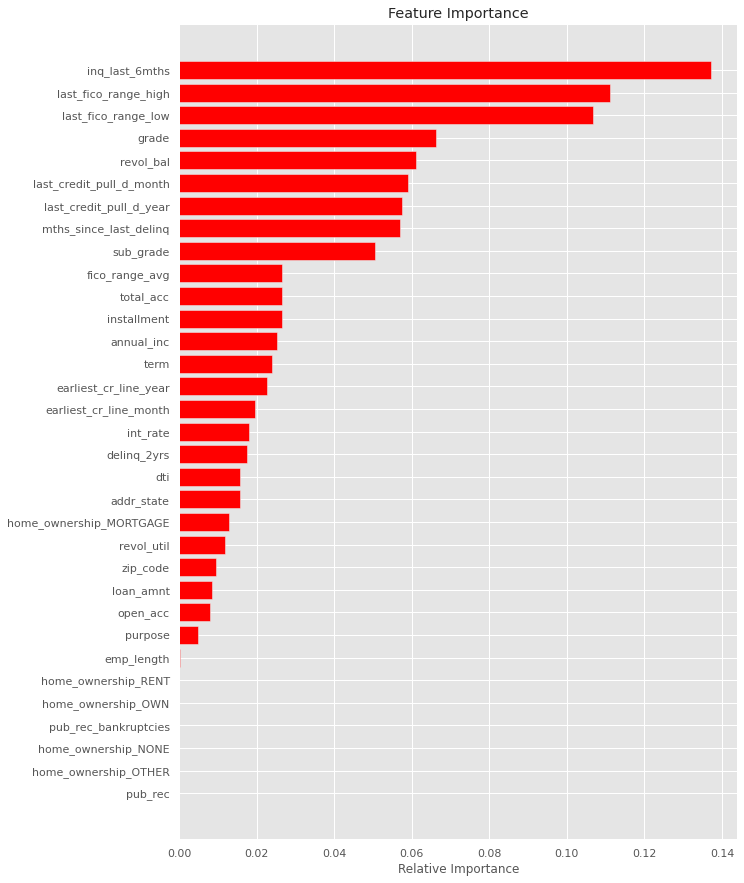

In [126]:
plt.figure(figsize=(10,15))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()